<a href="https://colab.research.google.com/github/naoya1110/road_following_by_classification/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Road Following by Classification - Train Model

## Introduction
Once you have finished data collection for you road following task, you need to train a model with your dataset.

### GPU
Please make sure we can use GPU for training a model.

In [ ]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

cuda


### General Python Packages
Let's import general Python packages.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm.notebook import tqdm
import shutil

## Data Preparation

### Upload & Extract Dataset

We need to upload the `dataset.zip` file in the file browser of the Google Colab. Uploading the zip file takes for a while depending the size of your dataset. After uploading is finished, you can extract it with the next command.

In [ ]:
! unzip -q dataset.zip

Now we can find a directory named ``dataset`` in the file browser.

#### *If your `dataset.zip` file is in your google drive*

First you need to mount your google drive with the next command.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Then extract the `dataset.zip` file. Remenber to change the file path appropriate for your `dataset.zip`.

In [ ]:
!unzip -q /path/to/your/dataset.zip

### Remove Broken Data
The dataset directory may contain some broken image data or unnecessary directories for some reasons. Such data will cause errors when we train the model. So it is better to remove such data before training.

In [ ]:
subdirs = sorted(os.listdir("dataset"))

for subdir in subdirs:
    filenames = os.listdir(os.path.join("dataset", subdir))
    for filename in filenames:
        path = os.path.join("dataset", subdir, filename)
        img = cv2.imread(path)
        if img is None:
            try:
                os.remove(path)
                print("Removed", path)
            except IsADirectoryError:
                shutil.rmtree(path)
                print("Removed", path)

### Number of Image Data
Let's check number of image data that we have now.

{'forward': 577, 'left': 296, 'right': 860}


<BarContainer object of 3 artists>

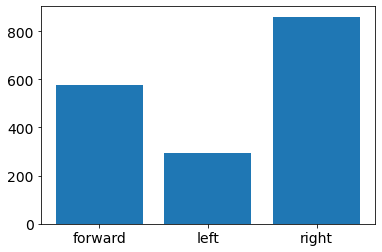

In [ ]:
n_files = {}

for subdir in subdirs:
    n_file =  len(os.listdir(os.path.join("dataset", subdir)))
    n_files[subdir]=n_file

print(n_files)
plt.rcParams["font.size"]=14
plt.bar(n_files.keys(), n_files.values())

### Create Dataset
Now we use the ``ImageFolder`` dataset class available with the ``torchvision.datasets`` package.  We attach transforms from the ``torchvision.transforms`` package to prepare the data for training.  

In [ ]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms


means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

dataset = datasets.ImageFolder(
    'dataset',
    transforms.Compose([
        transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ])
)

### Class Index
Let's check class index numbers that are automatically assigned.

In [ ]:
dataset.class_to_idx

{'forward': 0, 'left': 1, 'right': 2}

Then create classnames dictionary.

In [ ]:
classnames = {}

for key, value in dataset.class_to_idx.items():
    classnames[value] = key

classnames

{0: 'forward', 1: 'left', 2: 'right'}

### Train Test Split
We need to split the dataset into train and test dataset.

In [ ]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - 100, 100])

### Data Loaders
Then we can make data loaders for train and test dataset.

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=20,
    shuffle=True,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=20,
    shuffle=True,
    num_workers=2
)

## Model Building

### Model Architecture
We build a relatively simple CNN model but you can use any models you want.

In [ ]:
import torch.nn as nn

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(64*7*7, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),    # dropout layer
            nn.Linear(256, 3)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)  
        return x
    
model = Model().to(device)
print(model)

Model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3136, out_features=256, bias

### torchinfo

In [ ]:
! pip install torchinfo
from torchinfo import summary

for x_batch, _ in train_loader:
    break

input_shape = x_batch.shape
print(input_shape)

summary(model, input_shape)

torch.Size([20, 3, 224, 224])


Layer (type:depth-idx)                   Output Shape              Param #
Model                                    --                        --
├─Sequential: 1-1                        [20, 64, 7, 7]            --
│    └─Conv2d: 2-1                       [20, 64, 224, 224]        1,792
│    └─ReLU: 2-2                         [20, 64, 224, 224]        --
│    └─MaxPool2d: 2-3                    [20, 64, 112, 112]        --
│    └─Conv2d: 2-4                       [20, 64, 112, 112]        36,928
│    └─ReLU: 2-5                         [20, 64, 112, 112]        --
│    └─MaxPool2d: 2-6                    [20, 64, 56, 56]          --
│    └─Conv2d: 2-7                       [20, 64, 56, 56]          36,928
│    └─ReLU: 2-8                         [20, 64, 56, 56]          --
│    └─MaxPool2d: 2-9                    [20, 64, 28, 28]          --
│    └─Conv2d: 2-10                      [20, 64, 28, 28]          36,928
│    └─ReLU: 2-11                        [20, 64, 28, 28]          --


## Training

### Training Loop

Now we can train the model.

In [ ]:
import torch.optim as optim

model = Model()
model = model.to(device)

loss_func = nn.CrossEntropyLoss()                      # set loss function
optimizer = optim.Adam(model.parameters(), lr=1E-4)    # set optimizer
epochs = 20

best_model_path = 'best_model.pth'
best_accuracy = 0.0

# create empty lists for saving metrics during training
train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []

for epoch in range(epochs):
    print("-----------------------------")
    print(f"Epoch {epoch+1}/{epochs}")

    # initialize metrics
    train_correct_count = 0
    train_accuracy = 0
    train_loss = 0
    test_correct_count = 0
    test_accuracy = 0
    test_loss = 0

    #--- Training Phase ---#
    model.train()    # set model to training mode

    pbar = tqdm(train_loader)
    pbar.set_description("Train")

    for x_batch, y_batch in pbar:      # take mini batch data from train_loader
        
        x_batch = x_batch.to(device)     # load x_batch data on GPU
        y_batch = y_batch.to(device)     # load y_batch data on GPU
    
        optimizer.zero_grad()                  # reset gradients to 0
        p_batch = model(x_batch)               # do prediction
        loss = loss_func(p_batch, y_batch)     # measure loss
        loss.backward()                        # calculate gradients
        optimizer.step()                       # update model parameters

        train_loss += loss.item()                                # accumulate loss value
        p_batch_label = torch.argmax(p_batch, dim=1)             # convert p_batch vector to p_batch_label
        train_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #----------------------#

    #--- Evaluation Phase ---#
    with torch.no_grad():   # disable autograd for saving memory usage
        model.eval()        # set model to evaluation mode

        pbar = tqdm(test_loader)
        pbar.set_description("Test") 

        for x_batch, y_batch in pbar:   # take mini batch data from test_loader

            x_batch = x_batch.to(device)     # load x_batch data on GPU
            y_batch = y_batch.to(device)     # load y_batch data on GPU

            p_batch = model(x_batch)              # do prediction
            loss = loss_func(p_batch, y_batch)    # measure loss

            test_loss += loss.item()                                # accumulate loss value
            p_batch_label = torch.argmax(p_batch, dim=1)            # convert p_batch vector to p_batch_label
            test_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

            pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #------------------------#

    train_accuracy = train_correct_count/len(train_dataset)   # determine accuracy for training data
    test_accuracy = test_correct_count/len(test_dataset)      # determine accuracy for test data
    train_loss = train_loss/len(train_loader)                 # determine loss for training data
    test_loss = test_loss/len(test_loader)                    # determine loss for test data 

    # show and store metrics
    print(f"Train: Accuracy={train_accuracy:.3f} Loss={train_loss:.3f}, Test: Accuracy={test_accuracy:.3f} Loss={test_loss:.3f}")
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    test_accuracy_list.append(test_accuracy)
    test_loss_list.append(test_loss)

    # save the model if test accuracy is better than before
    if test_accuracy > best_accuracy:
        torch.save(model.state_dict(), best_model_path)
        print(f"Test accuracy improved from {best_accuracy:.3f} to {test_accuracy:.3f}")
        print(f"Model saved at {best_model_path}")
        best_accuracy = test_accuracy

-----------------------------
Epoch 1/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.487 Loss=1.016, Test: Accuracy=0.590 Loss=0.902
Test accuracy improved from 0.000 to 0.590
Model saved at best_model.pth
-----------------------------
Epoch 2/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.608 Loss=0.820, Test: Accuracy=0.700 Loss=0.682
Test accuracy improved from 0.590 to 0.700
Model saved at best_model.pth
-----------------------------
Epoch 3/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.719 Loss=0.683, Test: Accuracy=0.760 Loss=0.571
Test accuracy improved from 0.700 to 0.760
Model saved at best_model.pth
-----------------------------
Epoch 4/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.732 Loss=0.626, Test: Accuracy=0.760 Loss=0.521
-----------------------------
Epoch 5/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.750 Loss=0.586, Test: Accuracy=0.800 Loss=0.492
Test accuracy improved from 0.760 to 0.800
Model saved at best_model.pth
-----------------------------
Epoch 6/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.762 Loss=0.572, Test: Accuracy=0.780 Loss=0.498
-----------------------------
Epoch 7/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.765 Loss=0.547, Test: Accuracy=0.800 Loss=0.492
-----------------------------
Epoch 8/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.783 Loss=0.516, Test: Accuracy=0.810 Loss=0.462
Test accuracy improved from 0.800 to 0.810
Model saved at best_model.pth
-----------------------------
Epoch 9/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.775 Loss=0.518, Test: Accuracy=0.810 Loss=0.475
-----------------------------
Epoch 10/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.791 Loss=0.501, Test: Accuracy=0.820 Loss=0.456
Test accuracy improved from 0.810 to 0.820
Model saved at best_model.pth
-----------------------------
Epoch 11/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.790 Loss=0.484, Test: Accuracy=0.820 Loss=0.460
-----------------------------
Epoch 12/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.794 Loss=0.478, Test: Accuracy=0.820 Loss=0.425
-----------------------------
Epoch 13/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.801 Loss=0.466, Test: Accuracy=0.820 Loss=0.417
-----------------------------
Epoch 14/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.805 Loss=0.446, Test: Accuracy=0.830 Loss=0.452
Test accuracy improved from 0.820 to 0.830
Model saved at best_model.pth
-----------------------------
Epoch 15/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.822 Loss=0.438, Test: Accuracy=0.810 Loss=0.456
-----------------------------
Epoch 16/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.814 Loss=0.436, Test: Accuracy=0.820 Loss=0.426
-----------------------------
Epoch 17/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.813 Loss=0.419, Test: Accuracy=0.790 Loss=0.459
-----------------------------
Epoch 18/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.812 Loss=0.421, Test: Accuracy=0.810 Loss=0.427
-----------------------------
Epoch 19/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.816 Loss=0.409, Test: Accuracy=0.830 Loss=0.438
-----------------------------
Epoch 20/20


  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train: Accuracy=0.822 Loss=0.404, Test: Accuracy=0.830 Loss=0.433


### Learning Curves
Let's check the learning curves.

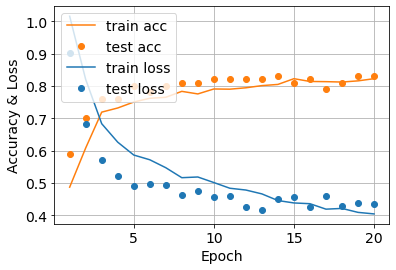

In [ ]:
plt.rcParams["font.size"]=14
real_epochs = np.arange(len(train_accuracy_list))+1

plt.plot(real_epochs, train_accuracy_list, c="#ff7f0e", label="train acc")
plt.plot(real_epochs, test_accuracy_list, lw=0, marker="o", c="#ff7f0e", label="test acc")
plt.plot(real_epochs, train_loss_list, c="#1f77b4", label="train loss")
plt.plot(real_epochs, test_loss_list, lw=0, marker="o", c="#1f77b4", label="test loss")

plt.xlabel("Epoch")
plt.ylabel("Accuracy & Loss")
plt.grid()
plt.legend()

## Evaluation

### Load The Best Model
Let's load the best model parameters.

In [ ]:
model.load_state_dict(torch.load(best_model_path))   # load model parameters to the initialized model

<All keys matched successfully>

### Test Accuracy
Let's check the accuracy for the test dataset.

In [ ]:
test_accuracy = 0

y_test_all = np.array([])
p_label_all = np.array([])

with torch.no_grad():    # disable autograd
    model.eval()         # set model to evaluation mode
    
    for x_batch, y_batch in test_loader:    # take mini batch data from train_loader
        x_batch = x_batch.to(device)        # transfer x_batch to gpu
        y_batch = y_batch.to(device)        # transfer y_batch to gpu
        p_batch = model(x_batch)            # do prediction

        p_batch_label = torch.argmax(p_batch, dim=1)       # convert p_batch vector to p_batch_label
        test_accuracy += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        y_test_all = np.append(y_test_all, y_batch.to("cpu").numpy())          # append y_batch in y_test_all
        p_label_all = np.append(p_label_all, p_batch_label.to("cpu").numpy())  # append p_batch_label in p_label_all

test_accuracy = test_accuracy/len(test_dataset)      # determine accuracy for test data
print(f"Test Accuracy = {test_accuracy:.3f}")

Test Accuracy = 0.810


### Confusion Matrix
Let's see the confusion matrix for the test dataset.

Text(0.5, 1.0, 'confusion matrix')

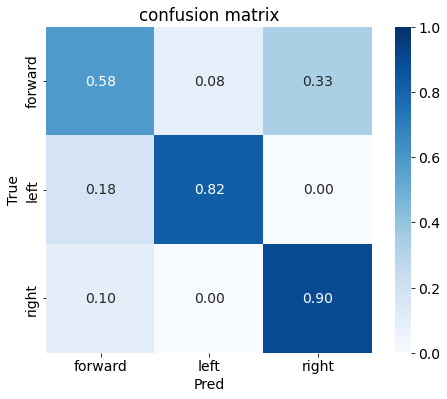

In [ ]:
from sklearn.metrics import confusion_matrix

cmx = confusion_matrix(y_test_all, p_label_all)

cmx_pct = np.zeros(cmx.shape)

for i in range(cmx.shape[0]):
    for j in range(cmx.shape[1]):
        cmx_pct[i, j] = cmx[i, j]/cmx[i, :].sum()

plt.figure(figsize=(8,6))
labels = classnames.values()

sns.heatmap(cmx_pct, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1,
            xticklabels=classnames.values(), yticklabels=classnames.values(), square=True)

plt.ylabel("True")
plt.xlabel("Pred")
plt.title("confusion matrix")

### Predictions for Test Data
Let's see the predictions for the test dataset.

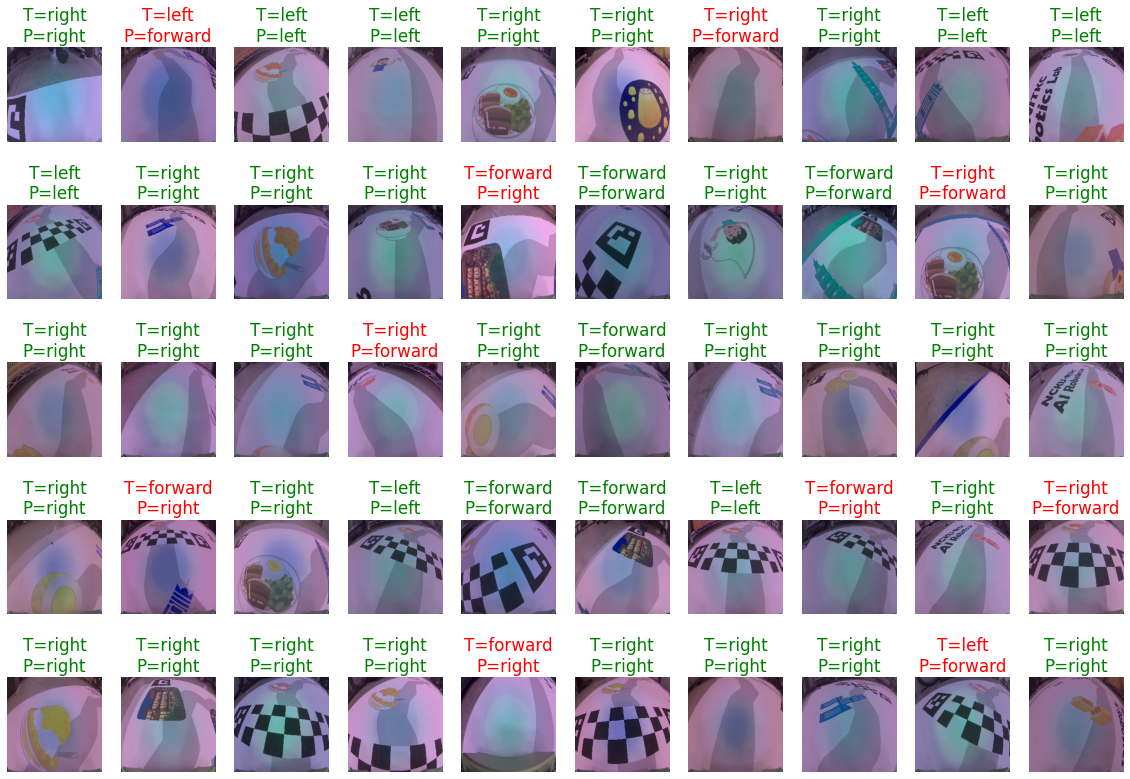

In [ ]:
plt.figure(figsize=(20, 14))

for i in range(50):
    image, _ = test_dataset[i]
    image = np.transpose(image, (1,2,0))

    image[:, :, 0] = image[:, :, 0]*stds[0]+means[0]
    image[:, :, 1] = image[:, :, 1]*stds[1]+means[1]
    image[:, :, 2] = image[:, :, 2]*stds[2]+means[2]

    plt.subplot(5, 10, i+1)
    plt.imshow(image)

    true_class = classnames[y_test_all[i]]
    pred_class = classnames[p_label_all[i]]
    if true_class == pred_class:
        color = "green"
    else:
        color = "red"
    plt.title(f"T={true_class}\nP={pred_class}", color=color)
    plt.axis("off")

## Download Model
Once you finished training, download `best_model.pth` from the file browser and upload it to your JetBot.